In [9]:
from os import listdir

#configure train dataset
train_root_path = "./the-simpsons-characters-dataset-TINY/simpsons_dataset"
character_directories = listdir(train_root_path)
#character_directories.remove('.DS_Store')
print("Train: {}".format(character_directories[:5]))

#configure test dataset
test_root_path = "./the-simpsons-characters-dataset-TINY/kaggle_simpson_testset"
test_image_names = listdir(test_root_path)
test_image_names.remove('.DS_Store')
print("Test: {}".format(test_image_names[:5]))


Train: ['selma_bouvier', 'rainier_wolfcastle', 'hans_moleman', 'groundskeeper_willie', 'bumblebee_man']
Test: ['ned_flanders_46.jpg', 'homer_simpson_29.jpg', 'ned_flanders_3.jpg', 'sideshow_bob_48.jpg', 'lenny_leonard_35.jpg']


### Calculate mean width and lenght from test images

In [10]:
import os, random
from scipy.misc import imread, imresize

width = 0
lenght = 0
num_test_images = len(test_image_names)

for i in range(num_test_images):
    path_file = os.path.join(test_root_path, test_image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//num_test_images
lenght_mean = lenght//num_test_images
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 38
Lenght mean: 37
Size mean dimension: 37


Size mean dimension will be used for the resizing process. __All the images will be scaled__ to __(37,37)__ since it's the average of the test images.

### Show some test examples

Label:comic_book_guy, Image:706, Shape:(39, 52, 3)


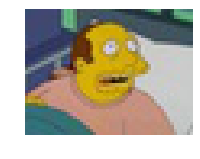

In [11]:
import matplotlib.pyplot as plt

idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
sample_image = imread(path_file)

print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
plt.figure(figsize=(3,3))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

### Making batches (resized)

In [0]:
def get_num_of_samples():
    count = 0
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        count += len(listdir(path))
        
    return count

def get_batch(batch_init, batch_size):
    data = {'image':[], 'label':[]}
    character_batch_size = batch_size//len(character_directories)
    character_batch_init = batch_init//len(character_directories)
    character_batch_end = character_batch_init + character_batch_size
    
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        images_list = listdir(path)
        for i in range(character_batch_init, character_batch_end):
            if len(images_list) == 0:
                continue
            #if this character has small number of features
            #we repeat them
            if i >= len(images_list):
                p = i % len(images_list)
            else:
                p = i
                
            path_file = os.path.join(path, images_list[p])
            image = imread(path_file)
            #all with the same shape
            image = imresize(image, (dim_size, dim_size))
            data['image'].append(image)
            data['label'].append(character)
    
    return data

def get_batches(num_batches, batch_size, verbose=False):
    #num max of samples
    num_samples = get_num_of_samples()
    #check number of batches with the maximum
    max_num_batches = num_samples//batch_size - 1
    
    if verbose:
        print("Number of samples:{}".format(num_samples))
        print("Batches:{} Size:{}".format(num_batches, batch_size))
    assert num_batches <= max_num_batches, "Surpassed the maximum number of batches"
        
    for i in range(0, num_batches):
        init = i * batch_size
        if verbose:
            print("Batch-{} yielding images from {} to {}...".format(i, init, init+batch_size))
        
        yield get_batch(init, batch_size)

In [13]:
#testing generator
batch_size = 500

for b in get_batches(10, batch_size, verbose=True):
    print("\t|- retrieved {} images".format(len(b['image'])))

Number of samples:20933
Batches:10 Size:500
Batch-0 yielding images from 0 to 500...


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


	|- retrieved 420 images
Batch-1 yielding images from 500 to 1000...
	|- retrieved 420 images
Batch-2 yielding images from 1000 to 1500...
	|- retrieved 420 images
Batch-3 yielding images from 1500 to 2000...
	|- retrieved 420 images
Batch-4 yielding images from 2000 to 2500...
	|- retrieved 420 images
Batch-5 yielding images from 2500 to 3000...
	|- retrieved 420 images
Batch-6 yielding images from 3000 to 3500...
	|- retrieved 420 images
Batch-7 yielding images from 3500 to 4000...
	|- retrieved 420 images
Batch-8 yielding images from 4000 to 4500...
	|- retrieved 420 images
Batch-9 yielding images from 4500 to 5000...
	|- retrieved 420 images


### Preprocessing data

In [0]:
from sklearn import preprocessing

#num characters
num_characters = len(character_directories)

#normalize
def normalize(x):
    #we use the feature scaling to have all the batches
    #in the same space, that is (0,1)
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

#one-hot encode
lb = preprocessing.LabelBinarizer()
lb = lb.fit(character_directories)

def one_hot(label):
    return lb.transform([label])


### Storing preprocessed batches on disk

In [0]:
num_batches = 40
batch_size = 500

In [35]:
import pickle
import numpy as np

cnt_images = 0
for cnt, b in enumerate(get_batches(num_batches, batch_size)):
    data = {'image':[], 'label':[]}
    
    for i in range( min(len(b['image']), batch_size) ):
        image = np.array( b['image'][i] )
        label = np.array( b['label'][i] )
        #label = label.reshape([-1,:])
        if len(image.shape) == 3:
          data['image'].append(normalize(image))
          data['label'].append(one_hot(label)[-1,:])
          cnt_images += 1
        else:
          print("Dim image < 3")
    
    with open("simpson_train_{}.pkl".format(cnt), 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    
print("Loaded {} train images and stored on disk".format(cnt_images))

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Dim image < 3
Loaded 16799 train images and stored on disk


In [36]:
#testing load from file
import pickle

with open('simpson_train_0.pkl', 'rb') as file:
    data = pickle.load(file)
    print("Example of onehot encoded:\n{}".format(data['label'][0]))
    print("Data shape: {}".format(data['image'][0].shape))

Example of onehot encoded:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0]
Data shape: (37, 37, 3)


### Building the Network

In [0]:
import tensorflow as tf

#helpers
def convolution(inputs, kernel_shape, stride_shape, output_depth):
    #convolution variables
    input_depth = inputs.get_shape().as_list()[3]
    filter_shape = kernel_shape + (input_depth, output_depth)
    dev = 1/np.sqrt(kernel_shape[0]*kernel_shape[1])
    filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=dev), name="filter_")
    stride_shape = (1,) + stride_shape + (1,)
    pool_shape = stride_shape
    bias_ = tf.Variable(tf.truncated_normal([output_depth], stddev=dev), name="bias_")
    
    #convolution
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    
    #pooling
    conv = tf.nn.max_pool(conv, pool_shape, stride_shape, padding='SAME')
    
    return conv

def classifier(inputs, num_outputs):
    #classifier variables
    num_inputs = inputs.get_shape().as_list()[1]
    dev = 1/np.sqrt(num_inputs)
    weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=dev), name="weights")
    bias = tf.Variable(tf.truncated_normal(num_outputs, stddev=dev), name="bias")

    #classifier
    logits = tf.add(tf.matmul(inputs, weights), bias)

    return logits

In [58]:
##building the network
import numpy as np

#remove previous weights, bias, etc
tf.reset_default_graph()

#shape
image_shape = (dim_size, dim_size, 3)
label_shape = (num_characters,)

#data
X = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.float32, (None,) + label_shape)

#conv
print(X.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 32)
print(conv.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 64)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 128)
print(conv.get_shape().as_list())
    
#before classifier
flatten_shape = np.prod(conv.get_shape().as_list()[1:])
flatten = tf.reshape(conv, [-1,flatten_shape])

#classifying
num_outputs = label_shape
logits = classifier(flatten, (40,))
logits = tf.nn.dropout(logits, 0.8)
logits = classifier(logits, num_outputs)

print("Inputs shape: {}".format(X.get_shape().as_list()[1:]))
print("Flatten shape: {}".format(flatten_shape))
print("Outputs shape: {}".format(logits.get_shape().as_list()[1]))

[None, 37, 37, 3]
[None, 10, 10, 32]
[None, 10, 10, 64]
[None, 3, 3, 128]
Inputs shape: [37, 37, 3]
Flatten shape: 1152
Outputs shape: 47


In [0]:
#loss and optmizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [61]:
from sklearn.model_selection import train_test_split

##Train the model
x_train = []
y_train = []
x_val = []
y_val = []

##
epochs = 50

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    
    for i in range(num_batches):
        fname = "simpson_train_{}.pkl".format(i)
        if os.path.exists(fname):   
            with open(fname, 'rb') as file:
                #print("Processing: {}".format(fname))
                data = pickle.load(file)
                x_train, x_val, y_train, y_val = train_test_split(data['image'], data['label'], test_size=0.2, random_state=42)

                feed_dict = {X: x_train, y: y_train}
                train_loss, _ = sess.run([cost, optimizer], feed_dict)

                feed_dict = {X: x_val, y: y_val}
                val_loss, acc = sess.run([cost, accuracy], feed_dict)

    print("Epoch:{} Training Loss:{:.4f} Validation Loss:{:.4f} Accuracy:{:.4f}".format(e, train_loss, val_loss, acc))

Epoch:0 Training Loss:3.3477 Validation Loss:3.5639 Accuracy:0.1429
Epoch:1 Training Loss:2.4918 Validation Loss:2.7942 Accuracy:0.3333
Epoch:2 Training Loss:1.9119 Validation Loss:2.4164 Accuracy:0.4405
Epoch:3 Training Loss:1.5968 Validation Loss:1.9463 Accuracy:0.5000
Epoch:4 Training Loss:1.3519 Validation Loss:1.7505 Accuracy:0.5595
Epoch:5 Training Loss:1.1231 Validation Loss:1.6901 Accuracy:0.6548
Epoch:6 Training Loss:1.0222 Validation Loss:1.4885 Accuracy:0.6548
Epoch:7 Training Loss:0.9306 Validation Loss:1.3455 Accuracy:0.6905
Epoch:8 Training Loss:0.8286 Validation Loss:1.4265 Accuracy:0.6786
Epoch:9 Training Loss:0.7101 Validation Loss:1.2588 Accuracy:0.7262
Epoch:10 Training Loss:0.6330 Validation Loss:1.4156 Accuracy:0.6786
Epoch:11 Training Loss:0.5593 Validation Loss:1.2232 Accuracy:0.7143
Epoch:12 Training Loss:0.5054 Validation Loss:1.1077 Accuracy:0.7262
Epoch:13 Training Loss:0.4766 Validation Loss:1.3206 Accuracy:0.6905
Epoch:14 Training Loss:0.4836 Validation Los

### Testing model

Label: Comic Book Guy
Prediction: Comic Book Guy


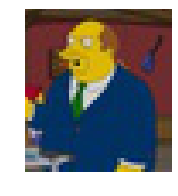

In [72]:
import warnings
warnings.filterwarnings('ignore')

#prediction
idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
sample_image = imread(path_file)
idx = int(random.uniform(0, len(y_val)))
    
test_image = sample_image
test_label = ' '.join([s.capitalize() for s in sample_name])

test_image_norm = normalize(imresize(sample_image, (dim_size, dim_size)))

prediction = sess.run(logits, {X:[test_image_norm]})
prediction = lb.inverse_transform(prediction)

#showing
print("Label: {}".format(test_label))
prediction = ' '.join([s.capitalize() for s in prediction[0].split('_')])
print("Prediction: {}".format(prediction))

plt.figure(figsize=(3,3))
plt.imshow(test_image)
plt.axis('off')
plt.show()